In [1]:
import jax.numpy as np
import numpy as onp
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt

import morphine
from morphine.matrixDFT import minimal_dft
import poppy

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as u

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0

import warnings
warnings.filterwarnings("ignore")


/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /Users/benjaminpope/pysynphot/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


In [2]:
D = 2.
wavelen = 1e-6

NPIX = 64

empty = morphine.OpticalSystem(npix=NPIX)
empty.add_pupil( morphine.CircularAperture(radius=1.),npix=NPIX)
empty.add_image() 
empty.add_pupil( morphine.CircularAperture(radius=0.9*D/2))
empty.add_detector( pixelscale=0.05, fov_arcsec=4. )

# Classical Lyot FPM, spot radius ~ 4 lam/D
anoroc = morphine.OpticalSystem(npix=NPIX)
anoroc.add_pupil( morphine.CircularAperture(radius=1.))
anoroc.add_image( morphine.CircularOcculter(radius=0.4)) 
anoroc.add_pupil( morphine.CircularAperture(radius=0.9*D/2))
anoroc.add_detector( pixelscale=0.05, fov_arcsec=4. )

corona = poppy.OpticalSystem(npix=NPIX)
corona.add_pupil( poppy.CircularAperture(radius=1.))
corona.add_image( poppy.CircularOcculter(radius=0.4)) 
corona.add_pupil( poppy.CircularAperture(radius=0.9*D/2))
corona.add_detector( pixelscale=0.05, fov_arcsec=4. )


wf = anoroc.input_wavefront(1e-6)
wfc = corona.input_wavefront(1e-6)

psf = empty.propagate(wf)
out, intermediates = anoroc.propagate(wf,return_intermediates=True)
default, inter_default = corona.propagate(wfc,return_intermediates=True)

In [3]:
for j in range(3):
    print('%.4f %.4f' % (inter_default[j].pixelscale.value,intermediates[j].pixelscale))

0.0312 0.0312
0.0516 0.0516
0.0312 0.0312


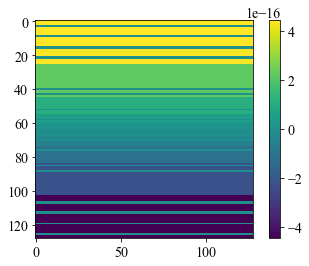

In [4]:
plt.imshow(intermediates[1].coordinates()[0]-inter_default[1].coordinates()[0])
plt.colorbar()

In [5]:
for j in range(3):
    print(inter_default[j].fov,intermediates[j].fov)

None 4.0
6.600473799907084 arcsec 6.600473799907083
6.600473799907084 arcsec 6.600473799907083


In [6]:
corona.planes[1].transmission.sum()

16194.96615345039

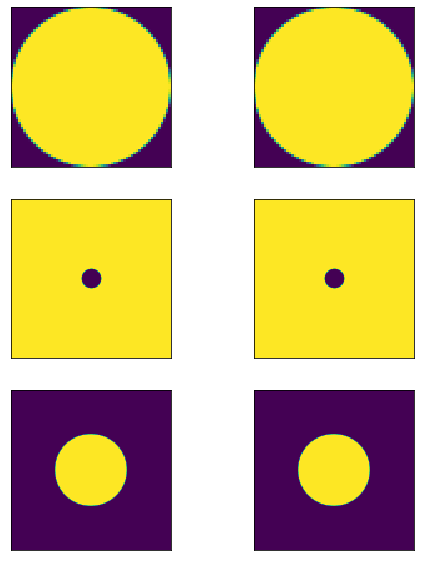

In [7]:
fig, axes = plt.subplots(3,2,figsize=(8,10))

for j in range(3):
    axes[j,0].imshow(corona.planes[j].transmission)
    axes[j,1].imshow(anoroc.planes[j].transmission)

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')


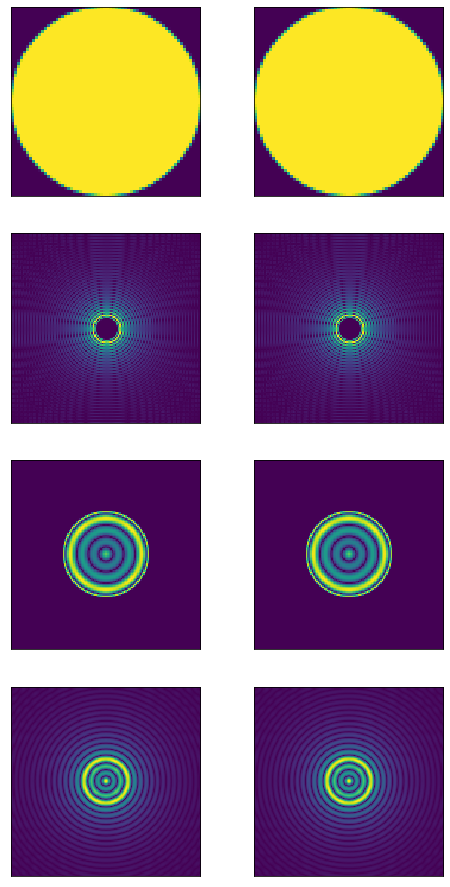

In [8]:
fig, axes = plt.subplots(4,2,figsize=(8,16))

for j in range(3):
    axes[j,0].imshow(np.abs(inter_default[j].wavefront))
    axes[j,1].imshow(np.abs(intermediates[j].wavefront))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

axes[3,0].imshow(default.amplitude)
axes[3,1].imshow(out.amplitude)

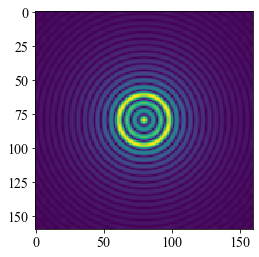

In [9]:
plt.imshow(default.amplitude)

In [10]:
arcsec2rad = np.pi/180./3600.
# experimental mathematics for the UV coords

class mywavefront(morphine.AnalyticOpticalElement):
    def __init__(self, wavelength, pupil, phasescreen, **kwargs):
        """ If your optic has adjustible parameters, then save them as attributes here """
        super().__init__()
        self.pupil = pupil
        self.wavelength = wavelength
        self.phasescreen = phasescreen

    def get_opd(self,wave):
        opd = self.phasescreen
        return opd

    def get_transmission(self, wave):
        transmission = self.pupil.get_transmission(wave)
        return transmission

    # behind the scenes morphine  will calculate:
    #    phasor = transmission = np.exp(1.j * 2 * np.pi / wave.wavelength * opd)
def calc_uv(wavefront,osys,npix=128):
    nlamd = arcsec2rad*wavefront.pixelscale * wavefront.shape[0] / WAVELENGTH*2*osys.planes[0].pupil_diam
    pupil = wavefront.intensity
    return minimal_dft(pupil, nlamd, npix)

## Now let's try to autodiff this

In [78]:
RADIUS = 1.0 # meters
WAVELENGTH = 1.0e-6 # meters
PIXSCALE = 0.0525 # arcsec / pix
FOV = 6 # arcsec
NWAVES = 1.0
NPIX = 128
D = RADIUS*2

# Classical Lyot FPM, spot radius ~ 4 lam/D
anoroc = morphine.OpticalSystem(npix=NPIX)
anoroc.add_pupil( morphine.CircularAperture(radius=RADIUS))
wf = anoroc.input_wavefront(WAVELENGTH)
wfe = mywavefront(WAVELENGTH,anoroc.planes[0],np.zeros_like(wf.coordinates()[0]))
anoroc.add_pupil(wfe)
anoroc.add_image( morphine.CircularOcculter(radius=0.4*RADIUS)) 
anoroc.add_pupil( morphine.CircularAperture(radius=0.9*D/2))
anoroc.add_detector( pixelscale=PIXSCALE, fov_arcsec=FOV )

psf,intermediate = anoroc.propagate_mono(WAVELENGTH)

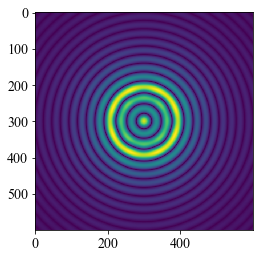

In [79]:
plt.imshow(psf.amplitude,interpolation='none')


In [50]:
def psf_from_phasescreen(phasescreen,wavel=WAVELENGTH):
    anoroc = morphine.OpticalSystem(npix=NPIX)
    anoroc.add_pupil( morphine.CircularAperture(radius=RADIUS))
    wf = anoroc.input_wavefront(WAVELENGTH)
    wfe = mywavefront(WAVELENGTH,anoroc.planes[0],phasescreen)
    anoroc.add_pupil(wfe)
    anoroc.add_image( morphine.CircularOcculter(radius=0.4*RADIUS)) 
    anoroc.add_pupil( morphine.CircularAperture(radius=0.9*D/2))
    anoroc.add_detector( pixelscale=PIXSCALE, fov_arcsec=FOV )

    psf,intermediate = anoroc.propagate_mono(WAVELENGTH)
    return psf,anoroc

def get_speckles_min(phasescreen):
    psf, osys = psf_from_phasescreen(phasescreen)
    return psf.intensity

get_speckles = jit(get_speckles_min)

def end_to_end(phasescreen):
    psf, osys = psf_from_phasescreen(phasescreen)
    return calc_uv(psf,osys,npix=NPIX+1)

def uv_phase(phasescreen):
    return np.angle(end_to_end(phasescreen))

zero_phase = np.zeros_like(wf.coordinates()[0])

end = get_speckles(zero_phase)

output = uv_phase(zero_phase)

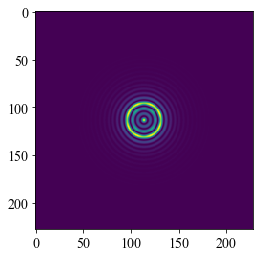

In [51]:
plt.imshow(np.abs(end))

In [52]:
from jax import grad, jacfwd, jacrev
from time import time as clock

In [53]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [54]:
%%timeit
speckles = get_speckles_min(zero_phase)

615 ms ± 58.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
%%timeit
speckles = get_speckles(zero_phase)

10.4 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:
speckles = get_speckles(zero_phase)

In [57]:
def sharp(phasescreen):
    return np.std(get_speckles(phasescreen))

In [58]:
test_grad = grad(sharp)

In [59]:
%%time
print(test_grad(zero_phase).max())

4.117363e-08
CPU times: user 1.53 s, sys: 147 ms, total: 1.68 s
Wall time: 1.38 s


In [60]:
phasegrad = jacfwd(get_speckles)

In [61]:
# %%memit 
# thisgrad = phasegrad(zero_phase)
# tic = clock()
# print(thisgrad.max())
# toc = clock()
# print(toc-tic)

In [62]:
%%time
thisgrad = phasegrad(zero_phase)
tic = clock()
print(thisgrad.max())
toc = clock()
print(toc-tic)

0.4481419
524.6131918430328
CPU times: user 6min 17s, sys: 3min 51s, total: 10min 9s
Wall time: 8min 45s


In [63]:
pupil_trans = anoroc.planes[0].transmission

In [64]:
(specpix/4),(3*specpix/4)

(57.0, 171.0)

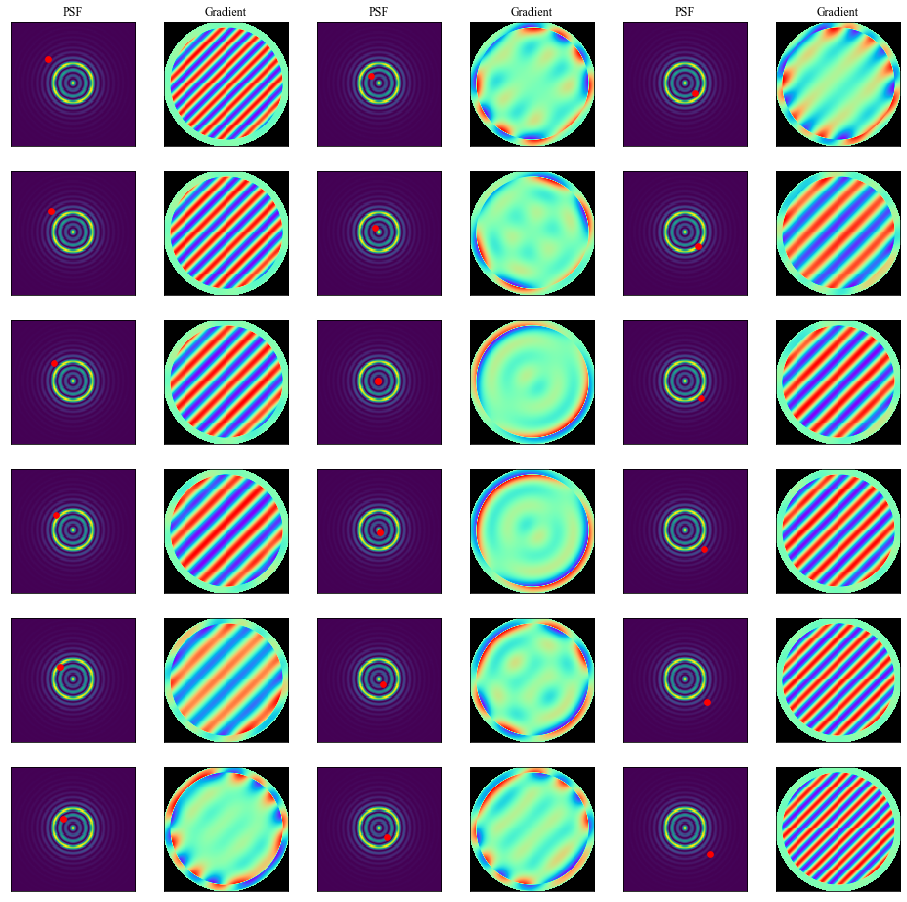

In [65]:
fig, ax = plt.subplots(6,6,figsize=(16, 16))
columns = 2
rows = 6
indices_array = np.round(np.linspace(speckles.shape[0]*0.4,speckles.shape[0]*0.6,18)).astype('int')
specpix = speckles.shape[0]
k = 0 
for j in [0,2,4]:
    for i in range(rows):
#         print(indices)
        indices = indices_array[k]
        phases = onp.copy(thisgrad[indices,indices,:,:])
        phases[anoroc.planes[0].transmission==0] = np.nan
        ax[i,1+j].imshow(phases,cmap=phasemap)
#         ax[i,1+j].set_xlim(32,128-32)
#         ax[i,1+j].set_ylim(128-32,32)
        ax[i,1+j].set_xticks([])
        ax[i,1+j].set_yticks([])
        if i ==0:
            ax[i,1+j].set_title('Gradient')
            ax[i,j].set_title('PSF')

        ax[i,j].imshow(speckles)
        ax[i,j].set_xlim((specpix/4),(3*specpix/4))
        ax[i,j].set_ylim((3*specpix/4),(specpix/4))
        ax[i,j].scatter(indices,indices,s=32,c='r')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        k += 1

plt.savefig('speckle_jacobian.png',bbox_inches='tight')
plt.savefig('/Users/benjaminpope/code/morphine/paper/speckle_jacobian.pdf',bbox_inches='tight')

In [66]:
pupil_trans = anoroc.planes[0].transmission

In [30]:
thisgrad.shape

(228, 228, 96, 96)

In [31]:
pupil_trans.shape

(96, 96)

In [32]:
# transfer = thisgrad[:,:,pupil_trans==1.].reshape(thisgrad.shape[0]**2,np.sum(pupil_trans==1.))

transfer= onp.array(thisgrad.reshape(thisgrad.shape[0]**2,thisgrad.shape[2]**2))
transfer = transfer[:,pupil_trans.ravel()==1.]
# transfer = transfer[support.ravel()==1.,:]


In [33]:
import scipy

In [34]:
%%time
u1, s1, v1 = scipy.linalg.svd(transfer.T,full_matrices=False,check_finite=True)
print(s1[0])

195.22238
CPU times: user 8min 10s, sys: 10.8 s, total: 8min 21s
Wall time: 2min 13s


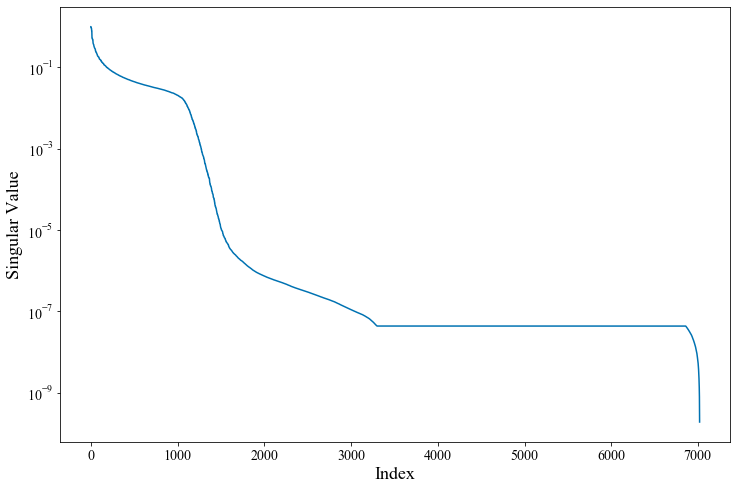

In [35]:
fig = plt.figure(figsize=(12.0,8.0))
plt.plot(s1/s1[0])
plt.yscale('log')
plt.ylabel('Singular Value')
plt.xlabel('Index')
# plt.title('Kernel Phase Singular Value Spectrum',fontsize=24,y=1.01)
# plt.title('Full Pupil',y=1.01,fontsize=20)
# plt.axvline(3300)
# plt.savefig('kerphi_singular.png',bbox_inches='tight')
plt.savefig('/Users/benjaminpope/code/morphine/paper/corona_singular.pdf',bbox_inches='tight')

In [36]:
from astropy.table import Table
tab = Table({'S1':s1/s1[0]})
tab.write('svd_corona.txt',format='ascii')

In [37]:
ripple = thisgrad[50,50,:,:]
ripple /= ripple.max() - ripple.min()
pattern = (ripple[pupil_trans==1]).ravel()

tiny = 0.1e-9
big = 5e-9

test_tiny = get_speckles(tiny*ripple)
test_big = get_speckles(big*ripple)

linear_map = np.dot(transfer,pattern).reshape(test_tiny.shape)

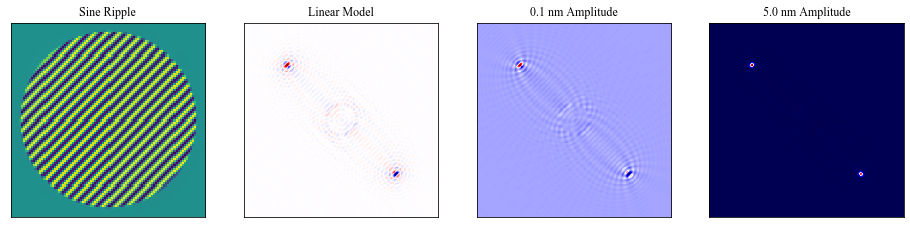

In [38]:

fig, axes = plt.subplots(1,4,figsize=(16,4))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')
    
axes[0].imshow(ripple)
axes[0].set_title('Sine Ripple',y=1.01)

axes[1].imshow(linear_map,cmap=mpl.cm.seismic)
axes[1].set_title('Linear Model',y=1.01)

axes[2].imshow((test_tiny-psf.intensity),cmap=mpl.cm.seismic)
axes[2].set_title('%.1f nm Amplitude' % (tiny*1e9),y=1.01)

axes[3].imshow((test_big-psf.intensity),cmap=mpl.cm.seismic)
axes[3].set_title('%.1f nm Amplitude' % (big*1e9),y=1.01)

plt.savefig('/Users/benjaminpope/code/morphine/paper/corona_nonlinearity.pdf', bbox_inches='tight')

### What do these kernel speckle maps look like?

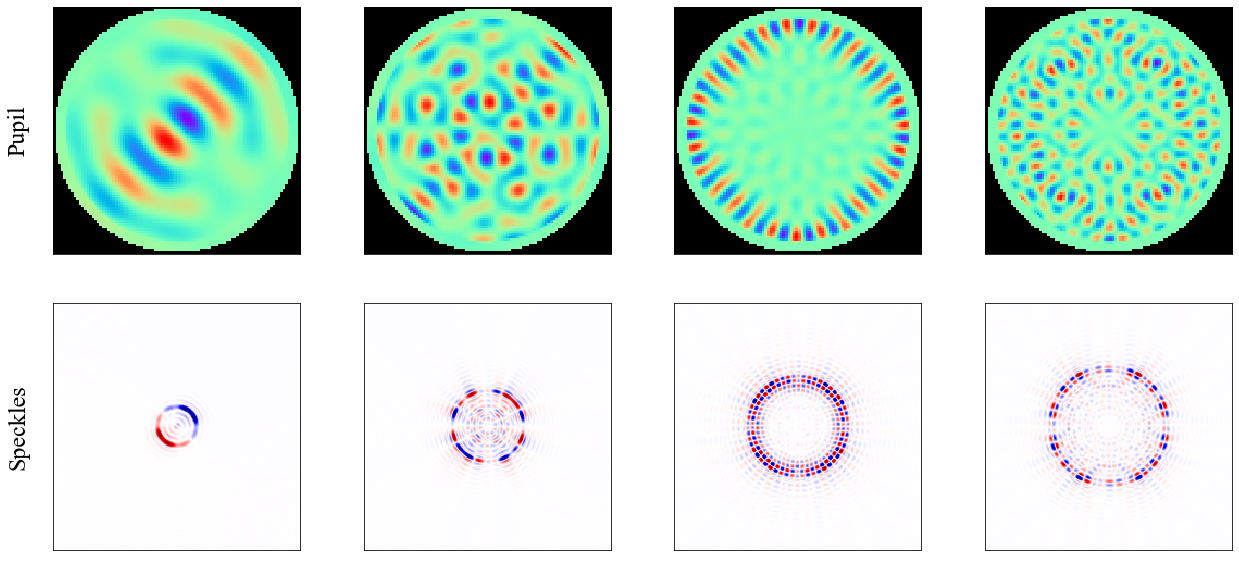

In [39]:
nsets = 4

fig, axes = plt.subplots(2,nsets,figsize=(8/3.*(nsets*2),10))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

axes[0,0].set_ylabel('Pupil',fontsize=24,labelpad=24)

axes[1,0].set_ylabel('Speckles',fontsize=24,labelpad=24)

for j in range(nsets):
    
    index = j*60
    mode = v1[index,:].reshape(thisgrad.shape[0],thisgrad.shape[1])

    axes[1,j].imshow(mode,cmap=mpl.cm.seismic)  
    
    wavefront = onp.ones_like(pupil_trans)
    wavefront[pupil_trans==1.] *= u1[:,index]
    wavefront[pupil_trans!=1.] = np.nan
    axes[0,j].imshow(wavefront,cmap=phasemap)
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='k')

plt.savefig('/Users/benjaminpope/code/morphine/paper/nonsingular_modes_corona.pdf',bbox_inches='tight')

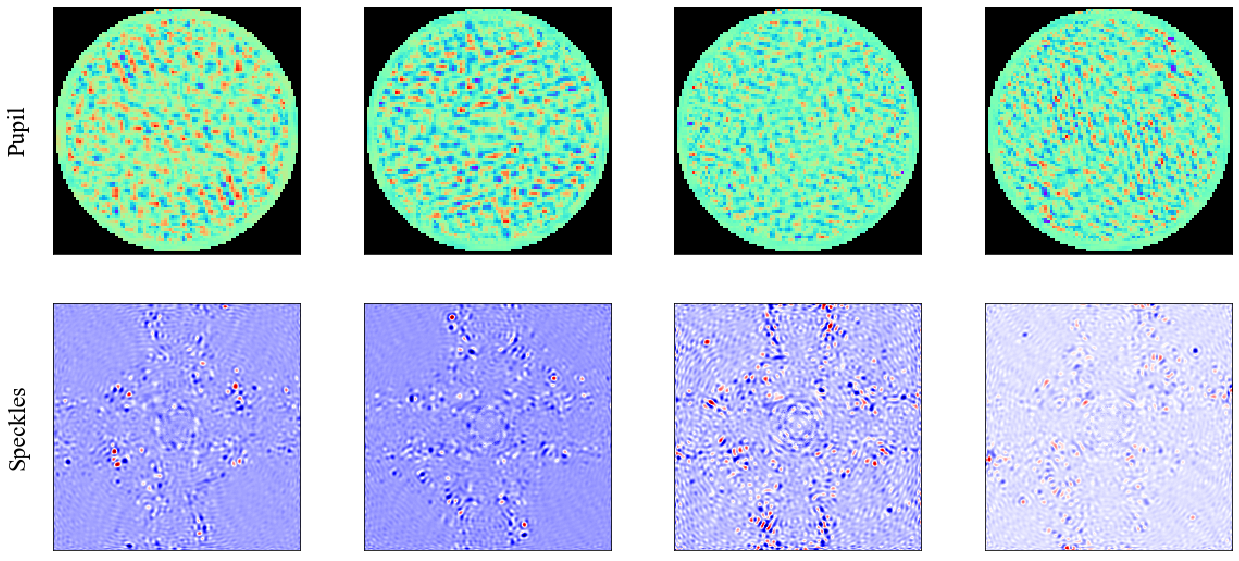

In [40]:
nsets = 4

fig, axes = plt.subplots(2,nsets,figsize=(8/3.*(nsets*2),10))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

axes[0,0].set_ylabel('Pupil',fontsize=24,labelpad=24)

axes[1,0].set_ylabel('Speckles',fontsize=24,labelpad=24)

for j in range(nsets):
    
    index = j*50 + 2000
    mode = v1[index,:].reshape(thisgrad.shape[0],thisgrad.shape[1])

    axes[1,j].imshow(mode,cmap=mpl.cm.seismic)  
    
    wavefront = onp.ones_like(pupil_trans)
    wavefront[pupil_trans==1.] *= u1[:,index]
    wavefront[pupil_trans!=1.] = np.nan
    axes[0,j].imshow(wavefront,cmap=phasemap)
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='k')


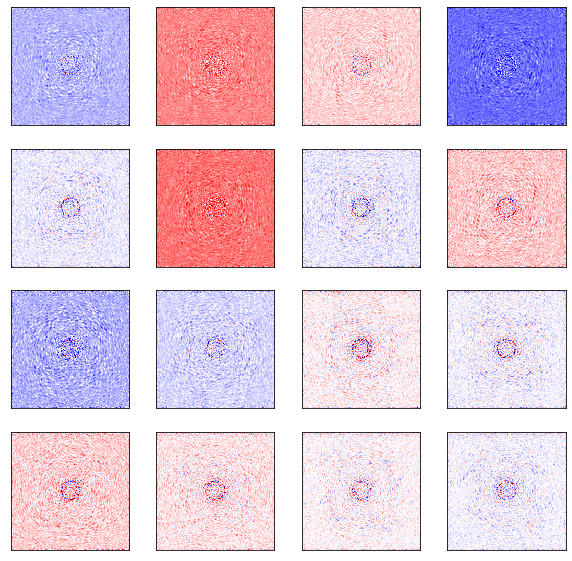

In [41]:
nsets = 4

fig, axes = plt.subplots(nsets,nsets,figsize=(10,10))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

for j, axis in enumerate(axes.ravel()):
    index = 3300+j*20
    mode = v1[index,:].reshape(thisgrad.shape[0],thisgrad.shape[1])

    axis.imshow(mode,cmap=mpl.cm.seismic)  
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='k')

plt.savefig('/Users/benjaminpope/code/morphine/paper/kernel_modes_corona.pdf',bbox_inches='tight')

### Can we use this basis like LOCI?

In [ ]:
def project_onto_basis(vec_in,basis):
    x, residuals, rank, s = onp.linalg.lstsq(basis,vec_in)
    return np.dot(basis,x)

In [ ]:
base = onp.array(end.ravel())

In [ ]:
basis = onp.vstack([v1,base]).T # add in the original

In [ ]:
anoroc.source_offset_r = 0.4

In [ ]:
tilted, intertilt = anoroc.propagate_mono(WAVELENGTH)

In [ ]:
plt.imshow(tilted.intensity**0.25)

In [ ]:
NZ = 10

zernikes = morphine.zernike.zernike_basis(NZ,npix=NPIX,outside=0.0)


In [ ]:
coefficients_sequence = 10e-9*onp.random.randn(NZ)

# Classical Lyot FPM, spot radius ~ 4 lam/D
aberrated = morphine.OpticalSystem(npix=NPIX)
aberrated.add_pupil( morphine.CircularAperture(radius=RADIUS))
thinlens = morphine.ZernikeWFE(radius=0.5*RADIUS, coefficients=coefficients_sequence,cached_zernikes=zernikes)
aberrated.add_pupil(thinlens)
aberrated.add_image( morphine.CircularOcculter(radius=0.4*RADIUS)) 
aberrated.add_pupil( morphine.CircularAperture(radius=0.9*D/2))
aberrated.add_detector( pixelscale=PIXSCALE, fov_arcsec=FOV )

blur,intermediate = aberrated.propagate_mono(WAVELENGTH,normalize='first')

In [ ]:
plt.imshow(blur.intensity**0.25)

In [ ]:
aberrated.source_offset_r = 1
tilted, intertilt = aberrated.propagate_mono(WAVELENGTH,normalize='first')
aberrated.source_offset_r = 0

In [ ]:
plt.imshow(tilted.intensity**0.25)

In [ ]:
contrast = 1e-3
science = contrast*tilted.intensity+blur.intensity

In [ ]:
plt.imshow(science)

In [ ]:
combined_zernikes = np.tensordot(coefficients_sequence,aberrated.planes[1].cached_zernikes,axes=(0,0))
print((combined_zernikes.max()-combined_zernikes.min())*1e9,'nm peak to peak')
plt.imshow(combined_zernikes)
plt.colorbar();

In [ ]:
trial_wf = combined_zernikes[pupil_trans==1]
linear = np.dot(transfer,trial_wf)
recon = (linear).reshape(speckles.shape)+psf.intensity

In [ ]:
fig, axes = plt.subplots(1,2)

axes[0].imshow(recon)
axes[1].imshow(blur.intensity)


In [ ]:
plt.plot(blur.intensity.ravel(),recon.ravel(),'.',markersize=1,alpha=0.5)
plt.xscale('log')
plt.yscale('log')

In [ ]:
kernel = v1[3300:,:]

no_planet = np.dot(kernel,blur.intensity.ravel()-base)
planet = np.dot(kernel,contrast*tilted.intensity.ravel())
total = np.dot(kernel,science.ravel()-base)
# calib = np.dot(kernel,base)

In [ ]:
fig = plt.figure(figsize=(12.0,8.0))

plt.plot(total,label='Star + Planet')
plt.plot(no_planet,label='No Planet')
plt.plot(planet,label='Just Planet')
plt.plot(calib,label='Calibrator')

plt.legend(fontsize=20)

In [ ]:
fig = plt.figure(figsize=(12.0,8.0))

plt.plot(total,no_planet,'.',markersize=4,label='No Planet')
plt.plot(total,planet,'.',markersize=4,label='Planet')

plt.legend(fontsize=20)

In [ ]:
plt.plot(science.ravel(),blur.intensity.ravel(),'.',label='No Planet')
plt.plot(science.ravel(),contrast*tilted.intensity.ravel()+base,'.',label='Planet')
# plt.xscale('log')
# plt.yscale('log')
plt.legend()